In [18]:
# Import e Configuração
# bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import geopy.geocoders
import plotly.graph_objects as go
import ipywidgets as widgets
from ipywidgets import fixed, interact, interact_manual
from matplotlib import pyplot as plt
import warnings

# dataset
data= pd.read_csv ('kc_house_data.csv')

# definindo formato de exibição
pd.set_option('display.float_format', lambda x: '%.2f' % x)
plt.rcParams['figure.figsize'] = (11,7)
warnings.filterwarnings('ignore')

In [19]:
data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.00,3,1.00,1180,5650,1.00,0,0,...,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650
1,6414100192,20141209T000000,538000.00,3,2.25,2570,7242,2.00,0,0,...,7,2170,400,1951,1991,98125,47.72,-122.32,1690,7639
2,5631500400,20150225T000000,180000.00,2,1.00,770,10000,1.00,0,0,...,6,770,0,1933,0,98028,47.74,-122.23,2720,8062
3,2487200875,20141209T000000,604000.00,4,3.00,1960,5000,1.00,0,0,...,7,1050,910,1965,0,98136,47.52,-122.39,1360,5000
4,1954400510,20150218T000000,510000.00,3,2.00,1680,8080,1.00,0,0,...,8,1680,0,1987,0,98074,47.62,-122.05,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.00,3,2.50,1530,1131,3.00,0,0,...,8,1530,0,2009,0,98103,47.70,-122.35,1530,1509
21609,6600060120,20150223T000000,400000.00,4,2.50,2310,5813,2.00,0,0,...,8,2310,0,2014,0,98146,47.51,-122.36,1830,7200
21610,1523300141,20140623T000000,402101.00,2,0.75,1020,1350,2.00,0,0,...,7,1020,0,2009,0,98144,47.59,-122.30,1020,2007
21611,291310100,20150116T000000,400000.00,3,2.50,1600,2388,2.00,0,0,...,8,1600,0,2004,0,98027,47.53,-122.07,1410,1287


In [20]:
# Verificando valores nulos
data.isnull().sum()

# Retirando os valores em branco
data.dropna(how='any',inplace=True) 

# Removendo atributos que não agregam à solução do problema
data = data.drop(columns=['sqft_living15','sqft_lot15'])

# Removendo registros duplicados 
data = data.drop_duplicates(subset='id')

# Número de linhas e colunas
data.shape

(21436, 19)

In [21]:
# Tipo dos dados
data.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
dtype: object

In [22]:
#  Transformações de datas
data['year'] = 'NA'
data['week_of_year'] = 'NA'
data['month'] = 'NA'
data['day'] = 'NA'
data['date'] = pd.to_datetime(data['date'], format="%Y-%m-%d")
data['year'] = data['date'].dt.year
data['week_of_year'] = data['date'].dt.isocalendar().week
data['month'] = data.date.dt.strftime("%Y-%m")
data['day'] = data['date'].dt.day
data['bathrooms'] = data['bathrooms'].round(0).astype('int64')
data['floors'] = data['floors'].astype('int64')


# correção de outlier
''' O registro com 33 quartos é um erro de digitação, considerando que os valores de preço, sala de estar, terreno e numero de banheiros estão na média dos imóveis de 3 quartos '''

data.loc[data['bedrooms']==33,'bedrooms'] = 3

# Adicionando novas variaveis
data['house_age_buyed']= data['year'].apply(lambda x: 'old_house' if x <= 2014 else 'new_house')

data['house_age']= data['yr_built'].apply(lambda x: 'old_house' if x <= 2000 else 'new_house')

data['dormitory_type']= data['bedrooms'].apply(lambda x: 'studio' if x == 1 else
                                                         'apartament' if x == 2 else
                                                         'house' if x > 2 else 'NA'  )

data['condition_type']= data['condition'].apply(lambda x: 'bad' if x <= 2 else
                                                         'regular' if (x==3) | (x==4) else
                                                         'good')


data['seasons'] = data['date'].apply(lambda x: 'Spring' if (x.day_of_year > 80) & (x.day_of_year <= 173) else
                                               'Summer' if (x.day_of_year > 173) & (x.day_of_year <= 267) else
                                               'Fall'   if (x.day_of_year > 267) & (x.day_of_year <= 356) else
                                               'Winter')
data.dtypes

id                          int64
date               datetime64[ns]
price                     float64
bedrooms                    int64
bathrooms                   int64
sqft_living                 int64
sqft_lot                    int64
floors                      int64
waterfront                  int64
view                        int64
condition                   int64
grade                       int64
sqft_above                  int64
sqft_basement               int64
yr_built                    int64
yr_renovated                int64
zipcode                     int64
lat                       float64
long                      float64
year                        int64
week_of_year               UInt32
month                      object
day                         int64
house_age_buyed            object
house_age                  object
dormitory_type             object
condition_type             object
seasons                    object
dtype: object

In [23]:
data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,long,year,week_of_year,month,day,house_age_buyed,house_age,dormitory_type,condition_type,seasons
0,7129300520,2014-10-13,221900.00,3,1,1180,5650,1,0,0,...,-122.26,2014,42,2014-10,13,old_house,old_house,house,regular,Fall
1,6414100192,2014-12-09,538000.00,3,2,2570,7242,2,0,0,...,-122.32,2014,50,2014-12,9,old_house,old_house,house,regular,Fall
2,5631500400,2015-02-25,180000.00,2,1,770,10000,1,0,0,...,-122.23,2015,9,2015-02,25,new_house,old_house,apartament,regular,Winter
3,2487200875,2014-12-09,604000.00,4,3,1960,5000,1,0,0,...,-122.39,2014,50,2014-12,9,old_house,old_house,house,good,Fall
4,1954400510,2015-02-18,510000.00,3,2,1680,8080,1,0,0,...,-122.05,2015,8,2015-02,18,new_house,old_house,house,regular,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,2014-05-21,360000.00,3,2,1530,1131,3,0,0,...,-122.35,2014,21,2014-05,21,old_house,new_house,house,regular,Spring
21609,6600060120,2015-02-23,400000.00,4,2,2310,5813,2,0,0,...,-122.36,2015,9,2015-02,23,new_house,new_house,house,regular,Winter
21610,1523300141,2014-06-23,402101.00,2,1,1020,1350,2,0,0,...,-122.30,2014,26,2014-06,23,old_house,new_house,apartament,regular,Summer
21611,291310100,2015-01-16,400000.00,3,2,1600,2388,2,0,0,...,-122.07,2015,3,2015-01,16,new_house,new_house,house,regular,Winter


In [24]:
# Estatística descritiva
num_attributes = data.select_dtypes( include=['int64', 'float64'] )

# Tendencia central
media = pd.DataFrame( num_attributes.apply( np.mean ) )
mediana = pd.DataFrame( num_attributes.apply( np.median ) )
std = pd.DataFrame( num_attributes.apply( np.std ) )

# Dispersão
std = pd.DataFrame( num_attributes.apply( np.std ) )
max_ = pd.DataFrame( num_attributes.apply( np.max ) )
min_ = pd.DataFrame( num_attributes.apply( np.min ) )

df1 = pd.concat( [max_, min_, media, mediana, std ], axis=1 ).reset_index()
df1.columns = ['attributes', 'mean', 'median', 'std', 'max', 'min']


In [25]:
# show df
df1

,attributes,mean,median,std,max,min
0,id,9900000190.00,1000102.00,4580765328.18,3904921185.00,2876522535.73
1,price,7700000.00,75000.00,540529.29,450000.00,367680.72
2,bedrooms,11.00,0.00,3.37,3.00,0.91
3,bathrooms,8.00,0.00,2.06,2.00,0.76
4,sqft_living,13540.00,290.00,2082.70,1920.00,919.13
5,sqft_lot,1651359.00,520.00,15135.64,7614.00,41537.65
6,floors,3.00,1.00,1.45,1.00,0.55
7,waterfront,1.00,0.00,0.01,0.00,0.09
8,view,4.00,0.00,0.24,0.00,0.77
9,condition,5.00,1.00,3.41,3.00,0.65


1 - Quais são os imóveis que a house rocket deveria comprar e por qual preço?

In [26]:
# Calculando a mediana
price_median = data[['price','zipcode']].groupby('zipcode').median().reset_index()
price_median  = price_median.rename(columns={'price':'region_price_median'})
price_median

,zipcode,region_price_median
0,98001,260000.00
1,98002,235000.00
2,98003,266500.00
3,98004,1150000.00
4,98005,765475.00
...,...,...
65,98177,557000.00
66,98178,279000.00
67,98188,265000.00
68,98198,265000.00


In [27]:
# Merge entre datasets
data = pd.merge(data, price_median, how='inner', on='zipcode')
data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,year,week_of_year,month,day,house_age_buyed,house_age,dormitory_type,condition_type,seasons,region_price_median
0,7129300520,2014-10-13,221900.00,3,1,1180,5650,1,0,0,...,2014,42,2014-10,13,old_house,old_house,house,regular,Fall,279000.00
1,4060000240,2014-06-23,205425.00,2,1,880,6780,1,0,0,...,2014,26,2014-06,23,old_house,old_house,apartament,regular,Summer,279000.00
2,4058801670,2014-07-17,445000.00,3,2,2100,8201,1,0,2,...,2014,29,2014-07,17,old_house,old_house,house,regular,Summer,279000.00
3,2976800796,2014-09-25,236000.00,3,1,1300,5898,1,0,0,...,2014,39,2014-09,25,old_house,old_house,house,regular,Fall,279000.00
4,6874200960,2015-02-27,170000.00,2,1,860,5265,1,0,0,...,2015,9,2015-02,27,new_house,old_house,apartament,regular,Winter,279000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21431,2525049086,2014-10-03,2720000.00,4,3,3990,18115,2,0,0,...,2014,40,2014-10,3,old_house,old_house,house,regular,Fall,1905000.00
21432,2525049113,2014-07-25,1950000.00,4,4,4065,18713,2,0,0,...,2014,30,2014-07,25,old_house,old_house,house,regular,Summer,1905000.00
21433,3262300485,2015-04-21,2250000.00,5,5,3410,8118,2,0,0,...,2015,17,2015-04,21,new_house,new_house,house,regular,Spring,1905000.00
21434,6447300365,2014-11-13,2900000.00,5,4,5190,14600,2,0,1,...,2014,46,2014-11,13,old_house,new_house,house,regular,Fall,1905000.00


In [28]:
# Condicional de compra
data['action'] = data[['price','region_price_median', 'condition']].apply(
    lambda x: 'buy' if (x['price'] < x['region_price_median']) & (x['condition'] >=3)
                                                                          else 'dont buy',axis=1)
    

In [29]:
data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,week_of_year,month,day,house_age_buyed,house_age,dormitory_type,condition_type,seasons,region_price_median,action
0,7129300520,2014-10-13,221900.00,3,1,1180,5650,1,0,0,...,42,2014-10,13,old_house,old_house,house,regular,Fall,279000.00,buy
1,4060000240,2014-06-23,205425.00,2,1,880,6780,1,0,0,...,26,2014-06,23,old_house,old_house,apartament,regular,Summer,279000.00,buy
2,4058801670,2014-07-17,445000.00,3,2,2100,8201,1,0,2,...,29,2014-07,17,old_house,old_house,house,regular,Summer,279000.00,dont buy
3,2976800796,2014-09-25,236000.00,3,1,1300,5898,1,0,0,...,39,2014-09,25,old_house,old_house,house,regular,Fall,279000.00,buy
4,6874200960,2015-02-27,170000.00,2,1,860,5265,1,0,0,...,9,2015-02,27,new_house,old_house,apartament,regular,Winter,279000.00,buy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21431,2525049086,2014-10-03,2720000.00,4,3,3990,18115,2,0,0,...,40,2014-10,3,old_house,old_house,house,regular,Fall,1905000.00,dont buy
21432,2525049113,2014-07-25,1950000.00,4,4,4065,18713,2,0,0,...,30,2014-07,25,old_house,old_house,house,regular,Summer,1905000.00,dont buy
21433,3262300485,2015-04-21,2250000.00,5,5,3410,8118,2,0,0,...,17,2015-04,21,new_house,new_house,house,regular,Spring,1905000.00,dont buy
21434,6447300365,2014-11-13,2900000.00,5,4,5190,14600,2,0,1,...,46,2014-11,13,old_house,new_house,house,regular,Fall,1905000.00,dont buy


In [31]:
# Filtro de compra
buy = data[data['action']=='buy'].sort_values(by=['condition','price'])
buy = buy[['id','zipcode','price','region_price_median','condition','action']]


# salvando no CSV
#buy.to_csv('datasets\kc_house_buy_report.csv', index=False)

# Printando o resultado
perc = round(buy.shape[0]/data.shape[0]*100,2)
perc

print('Foram encontrados {} imóveis dentro das condições acima sugeridos para compra, representando {}%'.format(len(buy), perc))

buy.head()



Foram encontrados 10499 imóveis dentro das condições acima sugeridos para compra, representando 48.98%


,id,zipcode,price,region_price_median,condition,action
18626,3421079032,98022,75000.00,279500.00,3,buy
2692,3883800011,98146,82000.00,309000.00,3,buy
17115,7999600180,98168,83000.00,237000.00,3,buy
16921,1523049188,98168,84000.00,237000.00,3,buy
16102,2422049104,98032,85000.00,249000.00,3,buy


In [42]:
buy.sum()

id                                                        48257665761764
zipcode                                                       1029717281
price                                                      4063385840.00
region_price_median                                        5112584106.50
condition                                                          35972
action                 buybuybuybuybuybuybuybuybuybuybuybuybuybuybuyb...
dtype: object

2 - Uma vez o imóvel comprado, qual o melhor momento para vende-lo e por qual preço?

Se o preço da compra é maior que a mediana da regiao + sazonalidade:
- O preço da venda sera igual ao preco da compra + 10%

Se o preço da compra é menor que a mediana da regiao + sazonalidade:
- O preço da compra sera igual ao preco da compra + 30%

Situação 1: Ao comprar apenas os indicados para compra conforme a primeira questão de negocio o resultado financeiro será:



In [32]:
# Criando um dataset separado para analise
sell_price = data[data['action'] == "buy"].copy().reset_index()
sell_price

,index,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,week_of_year,month,day,house_age_buyed,house_age,dormitory_type,condition_type,seasons,region_price_median,action
0,0,7129300520,2014-10-13,221900.00,3,1,1180,5650,1,0,...,42,2014-10,13,old_house,old_house,house,regular,Fall,279000.00,buy
1,1,4060000240,2014-06-23,205425.00,2,1,880,6780,1,0,...,26,2014-06,23,old_house,old_house,apartament,regular,Summer,279000.00,buy
2,3,2976800796,2014-09-25,236000.00,3,1,1300,5898,1,0,...,39,2014-09,25,old_house,old_house,house,regular,Fall,279000.00,buy
3,4,6874200960,2015-02-27,170000.00,2,1,860,5265,1,0,...,9,2015-02,27,new_house,old_house,apartament,regular,Winter,279000.00,buy
4,5,4268200055,2015-05-01,245000.00,3,2,1740,11547,1,0,...,18,2015-05,1,new_house,old_house,house,regular,Spring,279000.00,buy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10494,21423,3025300225,2014-10-31,1450000.00,5,3,3090,19865,1,0,...,44,2014-10,31,old_house,old_house,house,regular,Fall,1905000.00,buy
10495,21424,2470200020,2014-05-14,1880000.00,4,3,3260,19542,1,0,...,20,2014-05,14,old_house,old_house,house,regular,Spring,1905000.00,buy
10496,21426,3625049079,2014-08-01,1350000.00,3,2,2070,9600,1,0,...,31,2014-08,1,old_house,old_house,house,regular,Summer,1905000.00,buy
10497,21428,5427100150,2014-06-26,1410000.00,4,2,3250,16684,2,0,...,26,2014-06,26,old_house,old_house,house,regular,Summer,1905000.00,buy


In [35]:
# Condicional de venda
sell_price['sale_price'] = sell_price[['price','region_price_median']].apply(
    lambda x: x['price']*1.3 if (x['price'] < x['region_price_median']) 
    else x['price']*1.1,axis=1)

# Lucro
sell_price['gain'] = sell_price['sale_price'] - sell_price['price']

# show sell_price
sell_price

# salvando no CSV
#sell_price.to_csv('datasets\kc_house_sell_price_report.csv', index=False)


,index,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,day,house_age_buyed,house_age,dormitory_type,condition_type,seasons,region_price_median,action,sale_price,gain
0,0,7129300520,2014-10-13,221900.00,3,1,1180,5650,1,0,...,13,old_house,old_house,house,regular,Fall,279000.00,buy,288470.00,66570.00
1,1,4060000240,2014-06-23,205425.00,2,1,880,6780,1,0,...,23,old_house,old_house,apartament,regular,Summer,279000.00,buy,267052.50,61627.50
2,3,2976800796,2014-09-25,236000.00,3,1,1300,5898,1,0,...,25,old_house,old_house,house,regular,Fall,279000.00,buy,306800.00,70800.00
3,4,6874200960,2015-02-27,170000.00,2,1,860,5265,1,0,...,27,new_house,old_house,apartament,regular,Winter,279000.00,buy,221000.00,51000.00
4,5,4268200055,2015-05-01,245000.00,3,2,1740,11547,1,0,...,1,new_house,old_house,house,regular,Spring,279000.00,buy,318500.00,73500.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10494,21423,3025300225,2014-10-31,1450000.00,5,3,3090,19865,1,0,...,31,old_house,old_house,house,regular,Fall,1905000.00,buy,1885000.00,435000.00
10495,21424,2470200020,2014-05-14,1880000.00,4,3,3260,19542,1,0,...,14,old_house,old_house,house,regular,Spring,1905000.00,buy,2444000.00,564000.00
10496,21426,3625049079,2014-08-01,1350000.00,3,2,2070,9600,1,0,...,1,old_house,old_house,house,regular,Summer,1905000.00,buy,1755000.00,405000.00
10497,21428,5427100150,2014-06-26,1410000.00,4,2,3250,16684,2,0,...,26,old_house,old_house,house,regular,Summer,1905000.00,buy,1833000.00,423000.00


In [36]:
# Verificando zipcodes unicos
#data['zipcode'].unique()

In [39]:

# Dataset final de media de preço + sazonalidade
gain = sell_price[['seasons','price', 'sale_price', 'gain']].groupby('seasons').sum().reset_index()
gain

,seasons,price,sale_price,gain
0,Fall,942686464.00,1225492403.20,282805939.20
1,Spring,1223494005.00,1590542206.50,367048201.50
2,Summer,1236986085.00,1608081910.50,371095825.50
3,Winter,660219286.00,858285071.80,198065785.80


1219015752.0


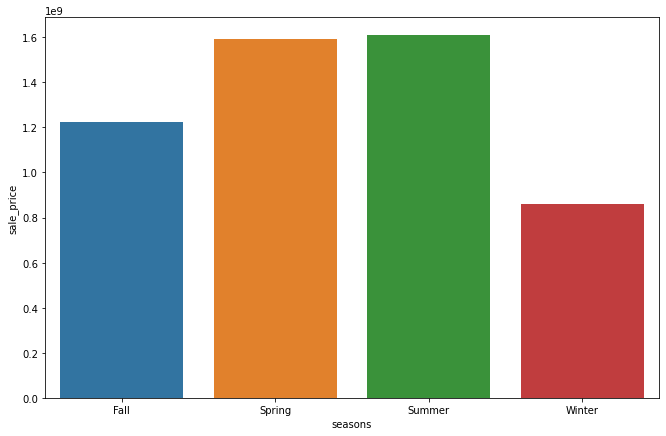

In [41]:
print(gain['gain'].sum())

# Plot
sns.barplot(data = gain, x = 'seasons', y = 'sale_price');


# Insights 

H1: Imóveis que possuem vista para água, são 30% mais caros, na média.

H2: Imóveis com data de construção menor que 1955, são 50% mais baratos, na média.

H3: Imóveis sem porão possuem sqrt_lot, são 50% maiores do que com porão.

H4: O crescimento do preço dos imóveis YoY ( Year over Year ) é de 10%

H5: Imóveis com 3 banheiros tem um crescimento MoM ( Month over Month ) de 15%

H6: Os apartamentos com vista para o mar são 15% mais baratos do que as casas.

H7: A venda de imoveis com vista para o mar no verão é 30% mais cara do que no inverno

H8: A venda de imoveis de condição regular é 10% maior que as de condição good.

H9: A venda de imoveis antigos é 10% maior que os novos por ano de construção

H10: Os imoveis reformados representam 15% dos imoveis em condição regular

In [47]:
def compartion_graph(labels,values,title,*kargs):
    
    sns.set_style("darkgrid")

    # criando figure e titulo
    fig = plt.figure(figsize=(10,6))
    plt.title(title,fontdict={'fontsize': 20})
    plt.xticks(fontsize=15)
    
    # plotando grafico
    g = sns.barplot(x=labels,y=values,palette='rocket')
    
    # incluindo labels nas barras
    for i in g.containers:
        g.bar_label(i, color='white', label_type= 'center',fontsize='x-large',fmt='%.2f')
    

    
    plt.show()

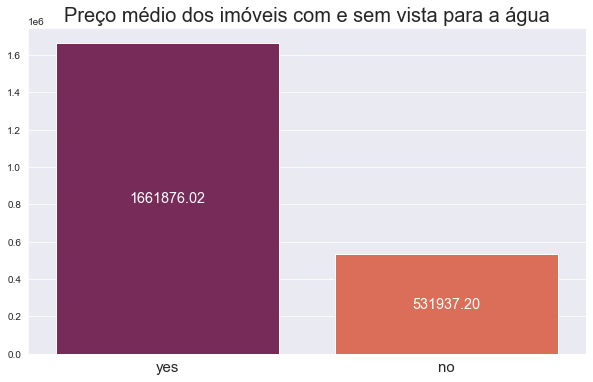

Diferença percentual de preços: 212% , então a afirmativa é falsa porque esse valor é maior que 30%


In [48]:
# H1: Imóveis que possuem vista para água, são 30% mais caros, na média.

waterfront1 = data.loc[data['waterfront'] == 1, 'price'].mean()
waterfront0 = data.loc[data['waterfront'] == 0, 'price'].mean()


waterfront = round((waterfront1 - waterfront0)*100/ (waterfront0))


compartion_graph(['yes','no'],[waterfront1,waterfront0],'Preço médio dos imóveis com e sem vista para a água')

print(f'Diferença percentual de preços: {waterfront}% , então a afirmativa é falsa porque esse valor é maior que 30%')

Diferença percentual de preços: 1% ,então a afirmativa é falsa porque esse valor é menor que 10%


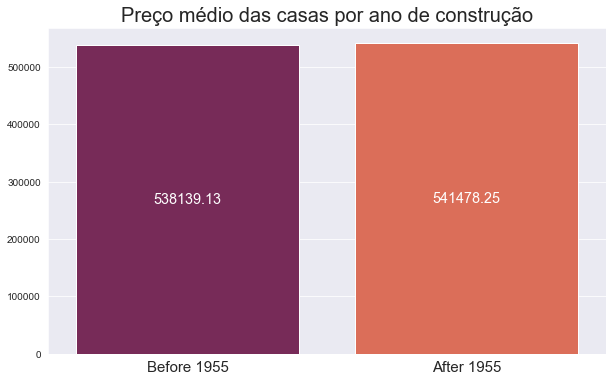

In [49]:
# H2: Imóveis com data de construção menor que 1955, são 50% mais baratos, na média.

yr_built1 = data.loc[data['yr_built'] < 1955 , 'price'].mean()
yr_built0 = data.loc[data['yr_built'] >= 1955 , 'price'].mean()

yr_built = round((yr_built0 - yr_built1)*100/ (yr_built1))

print(f'Diferença percentual de preços: {yr_built}% ,então a afirmativa é falsa porque esse valor é menor que 10%')

compartion_graph(['Before 1955','After 1955'],[yr_built1,yr_built0],'Preço médio das casas por ano de construção')

Diferença percentual de preços: 19%, então a afirmativa é falsa porque esse valor é menor que 50%


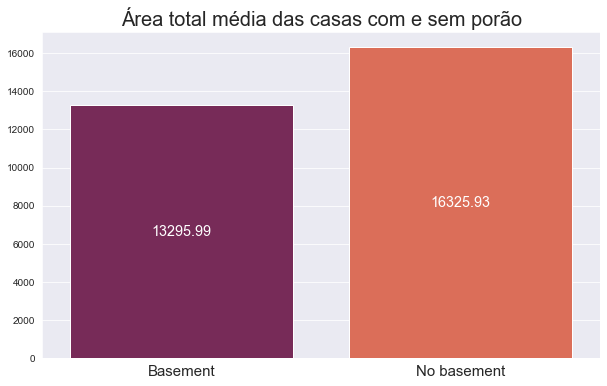

In [50]:
# H3: Imóveis sem porão possuem área total (sqrt_lot), são 50% maiores do que com porão.
data['basement'] = data['sqft_basement'].apply(lambda x: 1 if x!=0 else 0)
data


basement_lot = data[['basement','sqft_lot']].groupby('basement').mean().reset_index()
basement1= basement_lot.loc[1,'sqft_lot']
basement0= basement_lot.loc[0,'sqft_lot']

percent_basement = ((basement0 - basement1) / basement0) * 100
percent_basement

print(f'Diferença percentual de preços: {round(percent_basement,)}%, então a afirmativa é falsa porque esse valor é menor que 50%')

compartion_graph(['Basement','No basement'],[basement1,basement0],'Área total média das casas com e sem porão')


Diferença percentual de preços: 1%, então a afirmativa é falsa porque esse valor é menor que 10%


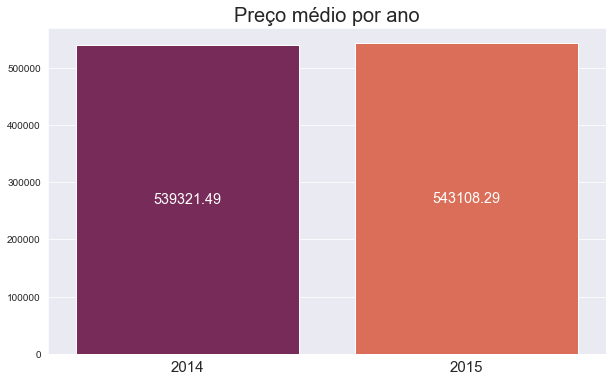

In [51]:
# H4: O crescimento do preço dos imóveis YoY ( Year over Year ) é de 10%
    
df = data[['year','price']].groupby('year').mean().reset_index()
price_2014 = df.loc[0,'price']
price_2015 = df.loc[1,'price']

percent_growth = ((price_2015 - price_2014)/price_2014) * 100
print(f'Diferença percentual de preços: {round(percent_growth,)}%, então a afirmativa é falsa porque esse valor é menor que 10%')

compartion_graph(['2014','2015'],[price_2014,price_2015],'Preço médio por ano')

A variação média dos preços YoY é de:  1 %


FileNotFoundError: [Errno 2] No such file or directory: 'imagens//Preço médio dos Imóveis por Mês.png'

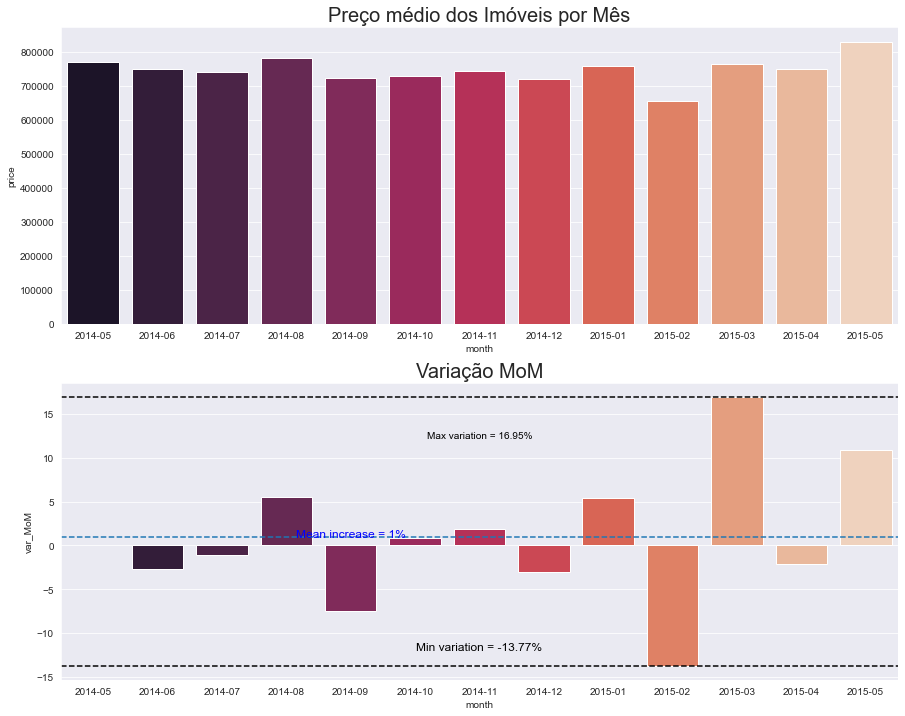

In [52]:
# H5: Imóveis com 3 banheiros tem um crescimento MoM (Month over Month) de 15%
# calculando variação entre dois meses consecutivos
df2 = data[data['bathrooms'] == 3][['price','month']].groupby('month').mean().reset_index()
df2['var_MoM'] = df2['price'].rolling(window=2).apply( lambda x: (x.iloc[1] / x.iloc[0] -1) * 100 )
df2
# variação média, máxima e mínima
var_MoM_mean = round(df2['var_MoM'].mean())
max_ = round(df2['var_MoM'].max(),2)
min_ = round(df2['var_MoM'].min(),2)
print('A variação média dos preços YoY é de: ',var_MoM_mean,'%')

fig,axes = plt.subplots(nrows=2,ncols=1,figsize=(15,12))

##### Plot do prço médio por mês

# criando figure e titulo
axes[0].set_title('Preço médio dos Imóveis por Mês',fontdict={'fontsize': 20})

# plotando grafico
sns.barplot(x=df2['month'],y=df2['price'],palette='rocket',ax=axes[0])

#### Plot da variação do preço médio por mês

# definidno titulo
axes[1].set_title('Variação MoM',fontdict={'fontsize':20})

# plotando gráfico
sns.barplot(x='month',y='var_MoM',data=df2,palette='rocket',ax=axes[1])

# defindo configurações de linha
axes[1].axhline(var_MoM_mean, ls='--')
axes[1].text(4, 1.8, f'Mean increase = {var_MoM_mean}%',
         rotation=0,
         horizontalalignment='center',
         verticalalignment='top',
         multialignment='center',
         color='blue',
        fontsize=12)
axes[1].axhline(df2['var_MoM'].min(), ls='--',color='black')
axes[1].text(6, -11, f'Min variation = {min_}%',
         rotation=0,
         horizontalalignment='center',
         verticalalignment='top',
         multialignment='center',
         color='black',
         fontsize=12)
axes[1].axhline(max_, ls='--',color='black',label='Max variation')
axes[1].text(6, 13, f'Max variation = {max_}%',
         rotation=0,
         horizontalalignment='center',
         verticalalignment='top',
         multialignment='center',
         color='black',
         fontsize=10)

plt.savefig('imagens//Preço médio dos Imóveis por Mês.png',dpi=300)

plt.tight_layout()



Diferença percentual de preços: 51% , então a afirmativa é verdadeira porque esse valor está entre os 50% e 60%


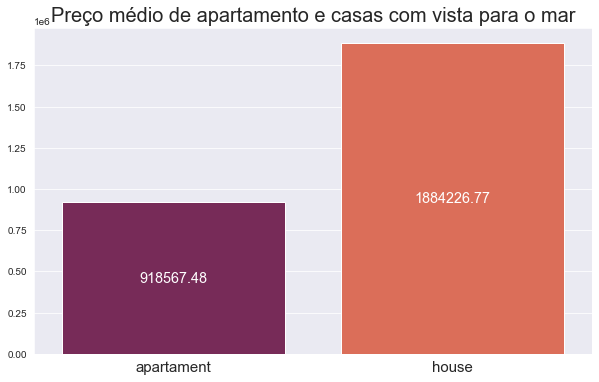

In [60]:
# H6: Os apartamentos com vista para o mar são em  média de 50% a 60% mais baratos do que as casas.
 
apartament = data.loc[(data['dormitory_type'] == 'apartament') & (data['waterfront'] == 1) , 'price'].mean()
house = data.loc[(data['dormitory_type'] == 'house') & (data['waterfront'] == 1) , 'price'].mean()

diference = round((house - apartament)*100/ (house))

print(f'Diferença percentual de preços: {diference}% , então a afirmativa é verdadeira porque esse valor está entre os 50% e 60%')

compartion_graph(['apartament','house'],[apartament,house],'Preço médio de apartamento e casas com vista para o mar')

TypeError: cannot concatenate object of type '<class 'float'>'; only Series and DataFrame objs are valid

Diferença percentual de preços: 12% , então a afirmativa é falsa porque esse valor é menor que 30%


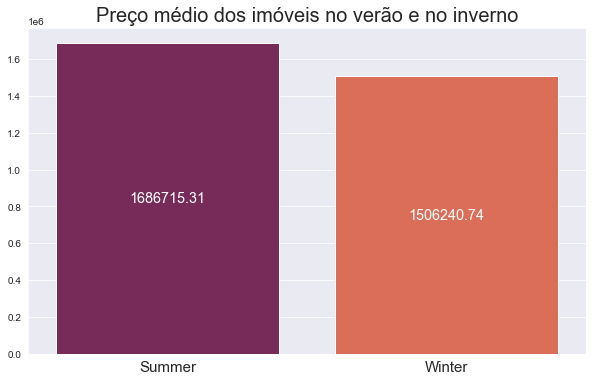

In [62]:
# H7: O valor de imoveis com vista para o mar no verão é 30% mais cara do que no inverno em média

type_houses = data[data['waterfront']==1][['seasons', 'waterfront', 'price']].groupby('seasons').mean().reset_index()

summer= type_houses.loc[type_houses['seasons']=='Summer', 'price'].mean()
winter = type_houses.loc[type_houses['seasons']=='Winter', 'price'].mean()

type_final = round((summer - winter)*100/ (winter))


print(f'Diferença percentual de preços: {type_final}% , então a afirmativa é falsa porque esse valor é menor que 30%')

compartion_graph(['Summer','Winter'],[summer,winter],'Preço médio dos imóveis no verão e no inverno')

Diferença percentual de preços: 8% , então a afirmativa é verdadeira porque esse valor é até 10% mais barato que as demais


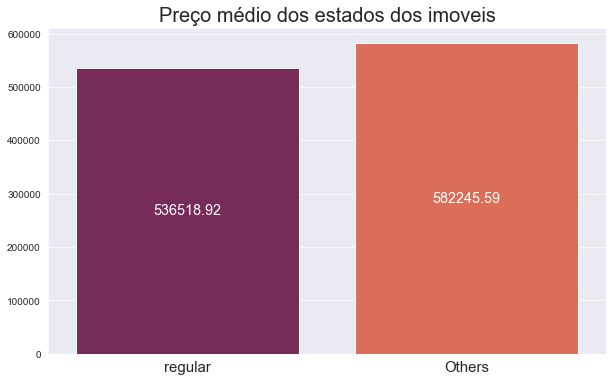

In [56]:
# H8: O valor de imoveis de condição regular é até 10% mais barata que os demais em média.


condition_1= data.loc[data['condition_type']== 'regular', 'price'].mean()
condition_0= data.loc[data['condition_type']!= 'regular', 'price'].mean()


condition_final = round((condition_0 - condition_1)*100/ (condition_0 ))

print(f'Diferença percentual de preços: {condition_final}% , então a afirmativa é verdadeira porque esse valor é até 10% mais barato que as demais')

compartion_graph(['regular','Others'],[condition_1,condition_0],'Preço médio dos estados dos imoveis')

Diferença percentual de preços: 15% , então a afirmativa é Falsa porque esse valor é 15% mais barato que as demais


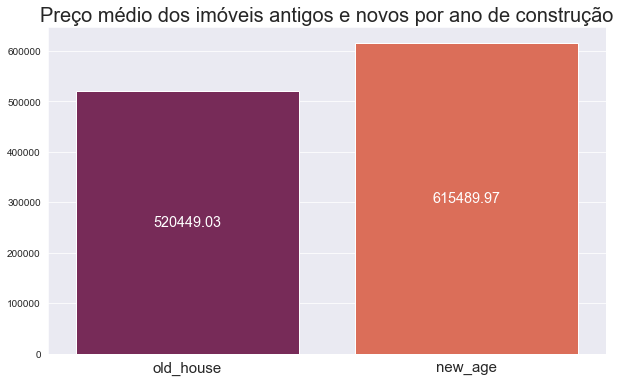

In [63]:
# H9: O valor de imoveis antigos é 10% maior que os novos por ano de construção.
old_age= data.loc[data['house_age']== 'old_house', 'price'].mean()
new_age= data.loc[data['house_age']!= 'old_house', 'price'].mean()


final_age = round((new_age - old_age)*100/ (new_age))

print(f'Diferença percentual de preços: {final_age}% , então a afirmativa é Falsa porque esse valor é 15% mais barato que as demais')

compartion_graph(['old_house','new_age'],[old_age,new_age],'Preço médio dos imóveis antigos e novos por ano de construção')

Diferença percentual de preços: 228% , então a afirmativa é Falsa porque esse valor é mais alto que 50%


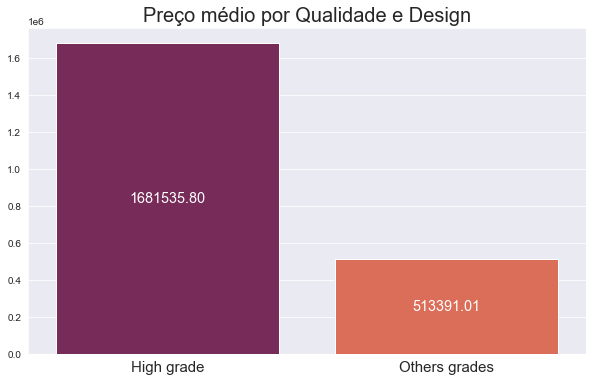

In [58]:
# H10: Casas com um alto grau de qualidade e design são até 50% mais caras em nédia.
high_grade = round(data.loc[data['grade'] >=11, 'price'].mean(),2)
others_grade = round(data.loc[data['grade'] < 11, 'price'].mean(),2)

diff = round(100*(high_grade - others_grade)/others_grade,)

print(f'Diferença percentual de preços: {diff}% , então a afirmativa é Falsa porque esse valor é mais alto que 50%')

compartion_graph(['High grade','Others grades'],[high_grade,others_grade],'Preço médio por Qualidade e Design')